In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


from phate import PHATE

import matplotlib.pyplot as plt

import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer import Predictive

import numpy as np

import matplotlib.pyplot as plt

import os
import sys

sys.path.append(os.path.abspath('..'))

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *
from src.utils.data_analysis_utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

%load_ext autoreload
%autoreload 2

## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


(80000, 2)


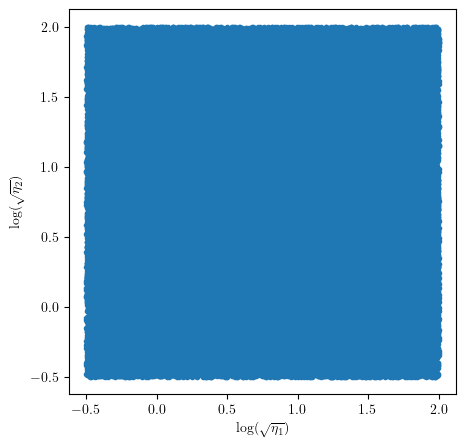

In [2]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = np.array([-0.5, 0.0])
eta_2_range = np.array([-.5, 0.0])

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="add_out_noise", noise = 0.001**2)

print(etas_train.shape)

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Defining Datasets

In [3]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32).to(device)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32).to(device)

## Training Parameters

In [4]:
model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 20,
    "num_layers": 4,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 5.], device=device, dtype=torch.float32),
    "device": device,
    "output_prior_conc_rate": torch.tensor([0.5, 1.0], device=device, dtype=torch.float32),
}

chkpt_dir = "../Model_Checkpoints/SVI/Aleatoric/"
chkpt_prefix = "Regular"

In [7]:
model = TurbulenceNetworkBayesian(**model_params).to(device)

display(model)

guide = AutoMultivariateNormal(model)

adam = Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO(num_particles=5))


TurbulenceNetworkBayesian(
  (layers): PyroModuleList(
    (0): PyroLinear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): PyroLinear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): PyroLinear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): PyroLinear(in_features=20, out_features=3, bias=True)
  )
)

## SVI Training

In [8]:
pyro.clear_param_store()

n_epochs = 400

for epoch in range(n_epochs):
    loss = 0
    for bx_train, by_train in train_loader:
        bx_train = bx_train.to(device)
        by_train = by_train.to(device)
        loss += svi.step(bx_train, by_train)

    if epoch % 5 == 0:
        with torch.no_grad():
            test_loss = svi.evaluate_loss(x_test, y_test)
        print(f"Epoch {epoch:8d} Test loss: {test_loss:20.4f}, Train loss: {loss:20.4f}")

Epoch        0 Test loss:         5661287.4349, Train loss:       274719042.0852
Epoch        5 Test loss:          696209.6735, Train loss:        72906124.2135
Epoch       10 Test loss:          422102.3900, Train loss:        30020578.3010
Epoch       15 Test loss:          220472.6539, Train loss:        18626920.8754
Epoch       20 Test loss:          103701.9378, Train loss:        13623772.6233
Epoch       25 Test loss:          134899.6845, Train loss:        10033269.0776
Epoch       30 Test loss:           90610.7125, Train loss:         7032486.9925
Epoch       35 Test loss:           87060.9807, Train loss:         6387534.6889
Epoch       40 Test loss:           14261.8768, Train loss:         4040032.9114
Epoch       45 Test loss:           23118.2606, Train loss:         3647469.5319
Epoch       50 Test loss:            8766.4861, Train loss:         2239565.9521
Epoch       55 Test loss:           79169.1330, Train loss:         1524541.0682
Epoch       60 Test loss:   

In [9]:
save_pyro_model(model, guide, chkpt_dir, chkpt_name=chkpt_prefix + '_SVI1')

## Loading Trained Model

In [10]:
pyro.clear_param_store()
model = TurbulenceNetworkBayesian(**model_params)

model, guide = load_pyro_model(model, chkpt_dir, device, chkpt_name=chkpt_prefix+'_SVI1')


model = model.to(device)
guide = guide.to(device)

Sharpness: 9.922772e-06
C_v: 0.2118645372908017
NLL diag: -7518453.442275743
Calibration Error: 0.04981148691560034
Miscalibration Area: 1.9122097959183673
tensor(0.0009, dtype=torch.float64)


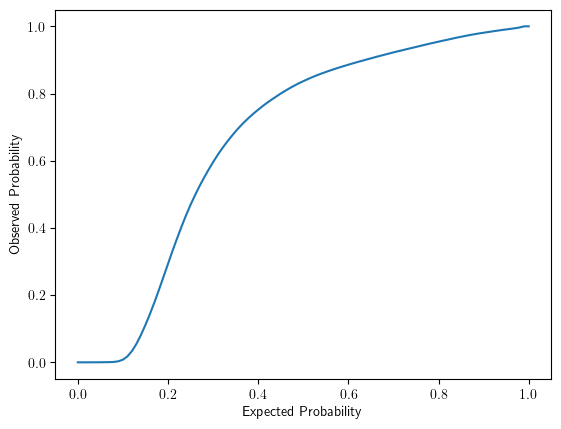

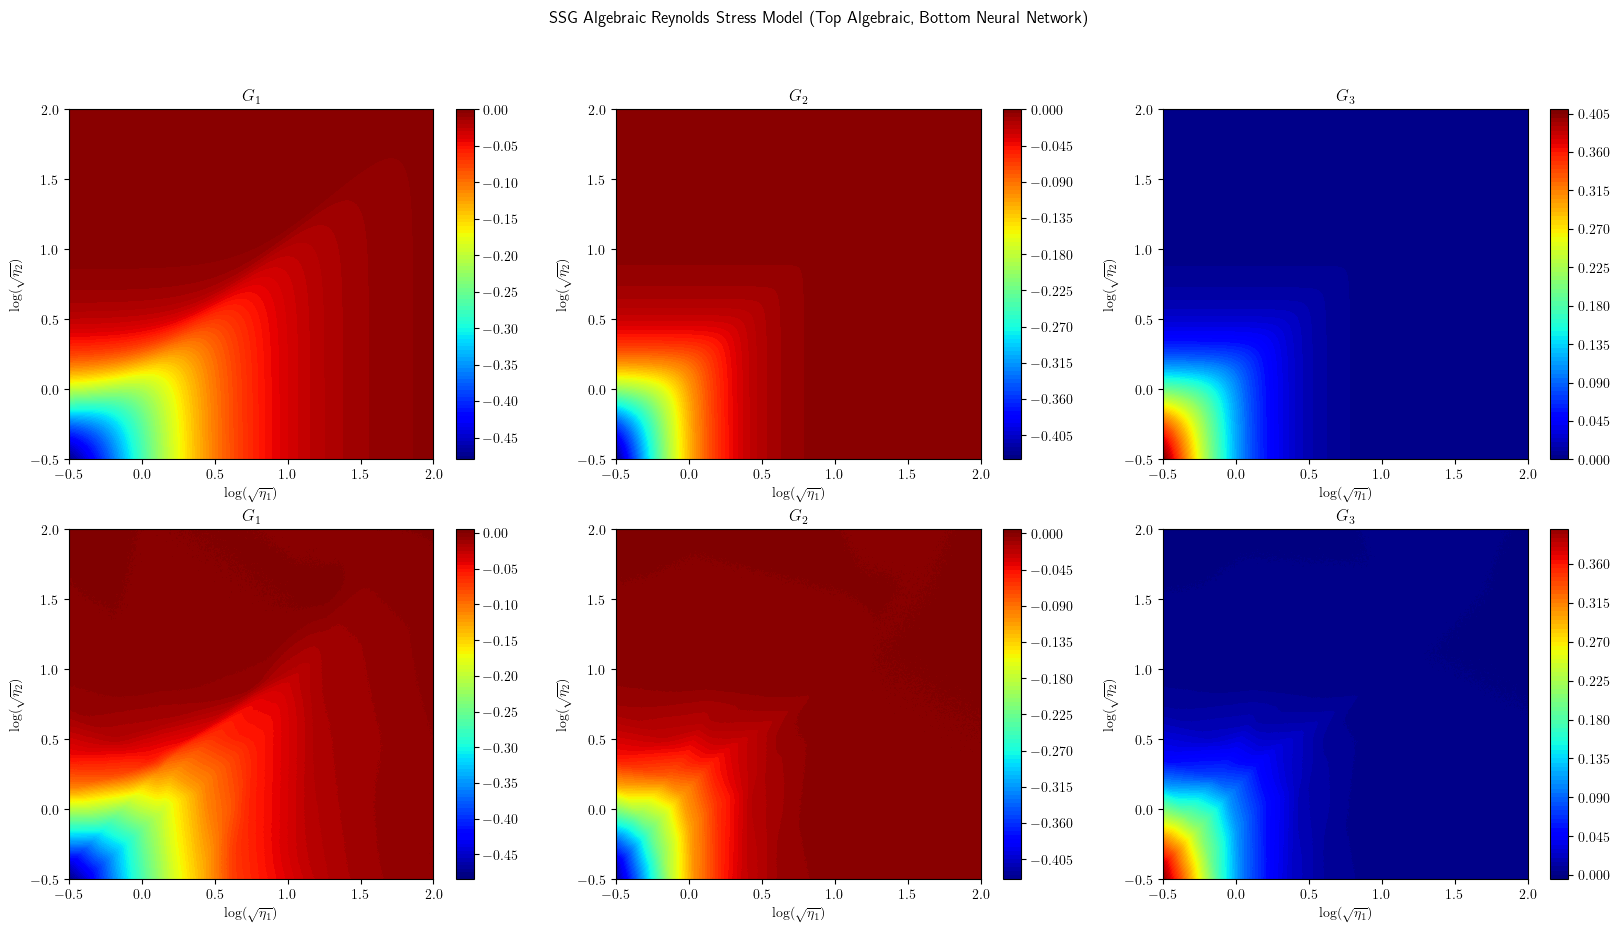

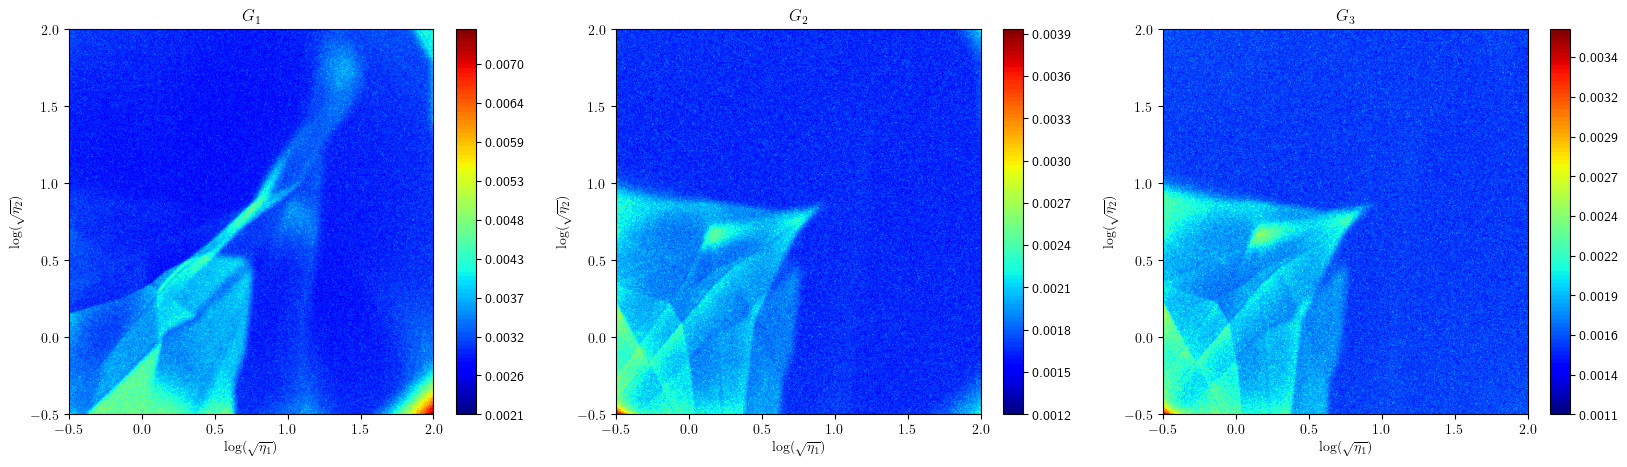

In [12]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model.data_size = etas.shape[0]
etas = x_scaler.transform(etas)

predictive = Predictive(model, guide=guide, num_samples=200, return_sites=("obs",))

pred = predictive(torch.tensor(etas, dtype=torch.float32).to(device))['obs']

for i in range(pred.shape[0]):
    pred[i] = torch.tensor(y_scaler.inverse_transform(pred[i].cpu().detach().numpy())).to(device)

pred_mean = torch.mean(pred, axis=0).detach().cpu()
pred_std = torch.std(pred, axis=0).detach().cpu()
pred_diag_cov = np.einsum('ji, ik->jik', pred_std.numpy()**2, np.eye(3))

sharpness = sharpness_score(pred_std.numpy(), axis_mean=0)
C_v = coefficient_of_variation(pred_std.numpy(), axis_mean=0)
nll_diag = negative_log_likelihood(target, pred_mean.numpy(), pred_diag_cov)
p_i, p_i_hat = calibration_curve(target, pred_mean.numpy(), pred_std.numpy(), num_bins=100)
calib_error = calibration_error(p_i, p_i_hat)
miscalib_area = miscalibration_area(p_i, p_i_hat, num_bins=10)

plt.plot(p_i, p_i_hat)
plt.xlabel('Expected Probability')
plt.ylabel('Observed Probability')


print("Sharpness:", sharpness)
print("C_v:", C_v)
print("NLL diag:", nll_diag)
print("Calibration Error:", calib_error)
print("Miscalibration Area:", miscalib_area)

np.save('../data/SVI/' + chkpt_prefix + '_Pred_Mean_Alea.npy', pred_mean.numpy())
np.save('../data/SVI/' + chkpt_prefix + '_Pred_Std_Alea.npy', pred_std.numpy())
#np.save('../data/SVI/' + chkpt_prefix + '_Pred_Samples.npy', pred_std.numpy())

del pred
del predictive
torch.cuda.empty_cache()

print(torch.mean(torch.abs(torch.tensor(target) - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim).numpy())

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim).numpy())

## Visualizing Functions

### Loading different trainings and predicting

In [52]:
chkpt_names = ['pyro1', "pyro2", 'pyro3']

predictions = []
labels = []

for i,chkpt in enumerate(chkpt_names):
    pyro.clear_param_store()
    model = TurbulenceNetworkBayesian(**model_params)
    model, guide = load_pyro_model(model, "Model_Checkpoints/SVI", device, chkpt_name=chkpt)
    predictive = Predictive(model, guide=guide, num_samples=400, return_sites=("obs",))
    preds = predictive(x_vis)['obs'].detach().cpu()
    for j in range(preds.shape[0]):
        preds[j] = torch.tensor(y_scaler.inverse_transform(preds[j].numpy()))
    preds = preds.reshape(preds.shape[0], -1)
    predictions.append(preds)
    labels.append(np.ones(preds.shape[0])*i)

y_trans = torch.tensor(y_scaler.inverse_transform(y_vis.cpu().numpy())).flatten().unsqueeze(0)

predictions.append(y_trans)
labels.append([labels[-1][-1]+1])

test_outputs = torch.cat(predictions, dim=0)    
labels = np.concatenate(labels)


error = torch.abs(test_outputs - y_trans)
print(f"ERROR: {torch.mean(torch.abs(test_outputs - y_trans))}")

ERROR: 0.002467005979269743


### Plotting Functions

Calculating PHATE...
  Running PHATE on 301 observations and 2400 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 0.71 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 0.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.13 seconds.
Calculated PHATE in 0.92 seconds.


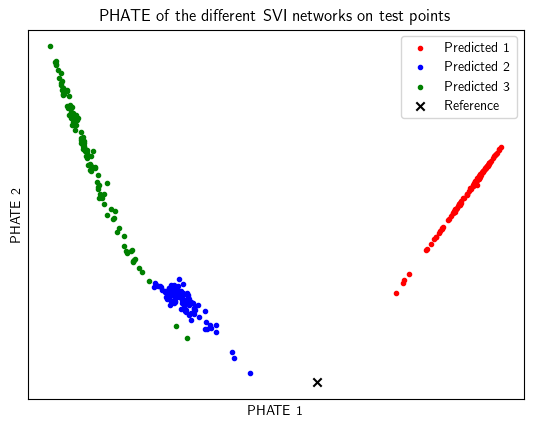

In [53]:
phate_op = PHATE(n_components=2)
phate_outputs = phate_op.fit_transform(test_outputs)


fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(phate_outputs[labels == 0, 0], phate_outputs[labels == 0, 1],label="Predicted 1", c='red', alpha=1, marker='.')

ax.scatter(phate_outputs[labels == 1, 0], phate_outputs[labels == 1, 1],label="Predicted 2", c='blue', alpha=1, marker='.')

ax.scatter(phate_outputs[labels == 2, 0], phate_outputs[labels == 2, 1],label="Predicted 3", c='green', alpha=1, marker='.')


ax.scatter(phate_outputs[labels == 3, 0], phate_outputs[labels == 3, 1],label="Reference", c='black', alpha=1, marker='x')

plt.title("PHATE of the different SVI networks on test points")
plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()
